# fastai Splitters and Transfer Learning

* What is that `splitter` param?
* Freezing models and layer groups/differential learning rates
* Custom splits based on a variety of situations

In [4]:
from fastai.vision.all import *

In [5]:
set_seed(99, True)
path = untar_data(URLs.PETS)/'images'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2,
    label_func=lambda x: x[0].isupper(), item_tfms=Resize(224))

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [7]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [ ]:
def  _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [55]:
class MyModel(Module):
    def __init__(self, body, head, head2):
        self.body = body
        self.head = head

        self.head2 = head2
    
    def forward(self, x):
        y1 = self.head(self.body(x))
        y2 = self.head2(self.body(x))
        return (y1 + y2)/2

In [56]:
body = create_body(resnet18)

In [ ]:
body[6:]

In [57]:
head = create_head(512, 2)

In [58]:
net = MyModel(body, head, create_head(512, 2))

In [ ]:
nn.Sequential(net.body, net.head)

In [90]:
net.head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [84]:
def my_splitter(m): return L(nn.Sequential(m.body, m.head2), m.head).map(params)

In [85]:
learn = Learner(dls, net, splitter=my_splitter)

In [86]:
learn.freeze()

In [ ]:
learn.summary()

In [ ]:
learn.model

In [91]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=7.585775847473997e-07)

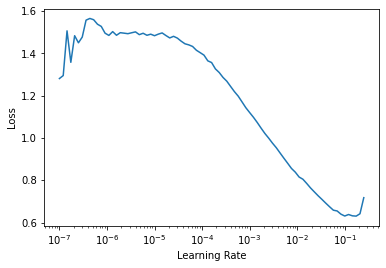

In [92]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, slice(1e-4, 1e-3, 1e-2))

In [93]:
from fastai.tabular.all import *

In [97]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [100]:
learn.fit_one_cycle(1, slice(1e-3, 1e-2, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.357905,0.353386,0.834152,00:07


In [ ]:
@delegates(optim.Adam)
def Adam(params, **kwargs): 
    "Convience function to make an Adam optimizer compatable with `Learner`"
    return OptimWrapper(optim.Adam(params, **kwargs))

In [111]:
def opt_func(params, **kwargs): return OptimWrapper(torch.optim.Adam(params, **kwargs))

In [115]:
def convert_params(o:list) -> list:
    """
    Converts `o` into Pytorch-compatable param groups
    
    `o` should be a set of layer-groups that should be split in the optimizer
    
    Example:
    
    ```python
    def splitter(m): return convert_params([[m.a], [m.b]])
    ```
    
    Where `m` is a model defined as:
    
    ```python
    class RegModel(Module):
      def __init__(self): self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
      def forward(self, x): return x*self.a + self.b
    ```
    """
    splitter = []
    for group in o:
        if isinstance(group, dict): return o
        splitter.append({'params':group})
    return splitter

In [116]:
class MyModel(Module):
    def __init__(self, body, head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        y1 = self.head(self.body(x))
        return y1

In [117]:
net = MyModel(body, head)

In [149]:
def splitter(m): return convert_params(L(m.body, m.head).map(params))

In [154]:
set_seed(99, True)
path = untar_data(URLs.PETS)/'images'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2,
    label_func=lambda x: x[0].isupper(), item_tfms=Resize(224))
learn = Learner(dls, net, splitter=splitter, opt_func=opt_func, train_bn=False)

In [155]:
learn.freeze()

In [156]:
learn.summary()

MyModel (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                         